In [2]:
import matplotlib.pyplot as plt
from utils import normal_grad, tweedies, estimate_distribution, estimate_gradient

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import os
import sys

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

def generate_circular(n, size):
    radians = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    x = size * np.cos(radians)
    y = size * np.sin(radians)
    return x, y

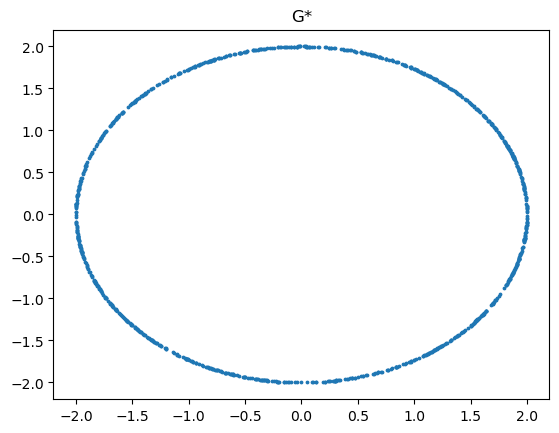

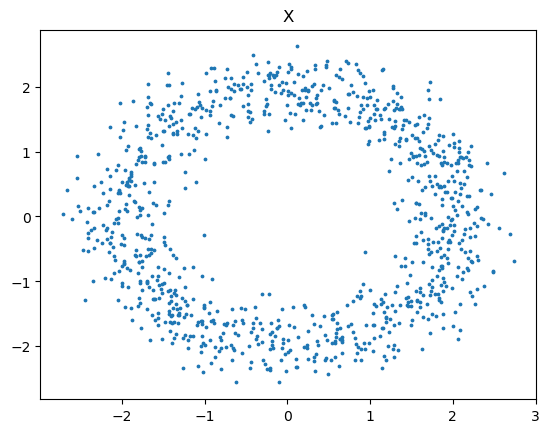

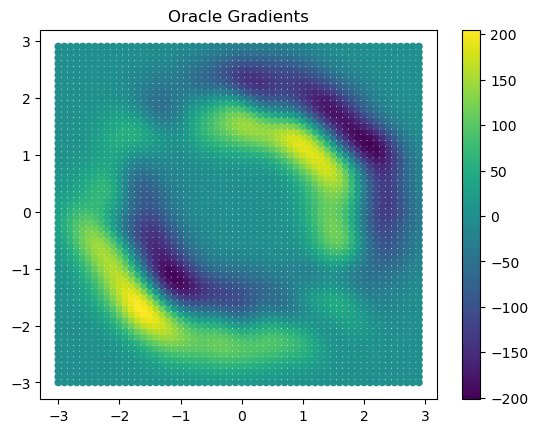

In [2]:
n=1000
x_orig, y_orig = generate_circular(n, 2)

# Plotting Ground Truth Points
plt.scatter(x_orig, y_orig, s=3)
plt.title('G*')
plt.show()

x = x_orig + np.random.normal(loc=0.0, scale=0.3, size=n)
y = y_orig + np.random.normal(loc=0.0, scale=0.3, size=n)

# Plotting Noisy Points
plt.scatter(x, y, s=3)
plt.title('X')
plt.show()

x_grid = torch.arange(-3,3,0.1)
y_grid = torch.arange(-3,3,0.1)
grid = torch.cartesian_prod(x_grid, y_grid)

data = torch.stack([torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)],dim=1)
# Ground Truth Gradient Plot
gradients = torch.zeros_like(grid)
for i in data:
    gradients += normal_grad(grid - i, sd = torch.tensor([0.3,0.3]))
plt.scatter(grid[:,0], grid[:,1], c=torch.sum(gradients, dim=1), s=20)
plt.colorbar()
plt.title('Oracle Gradients')
plt.show()

In [3]:
n_steps=200
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-5, 1e-2, 'linear',
                 model, loss, optimizer)

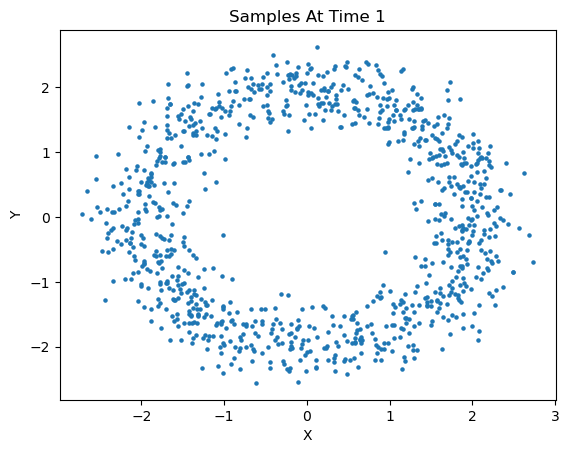

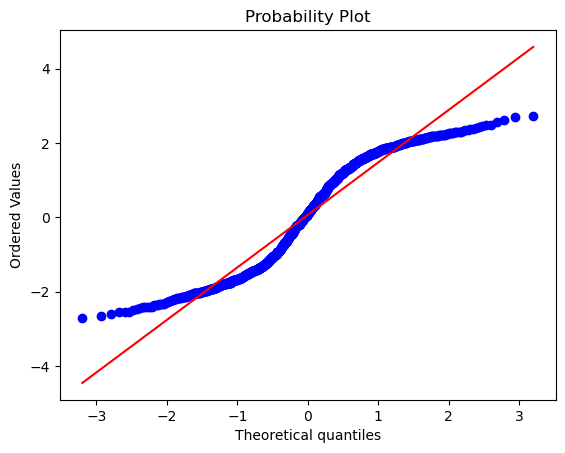

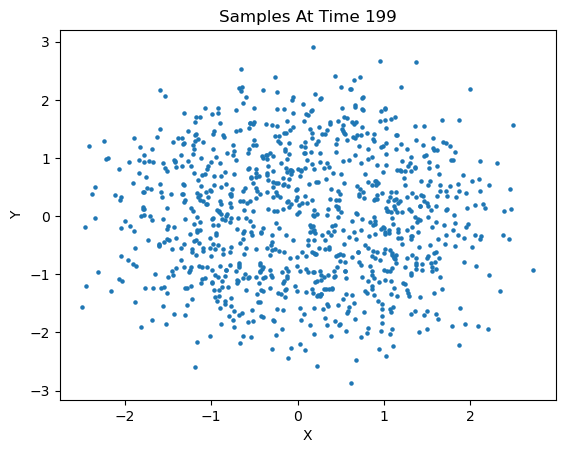

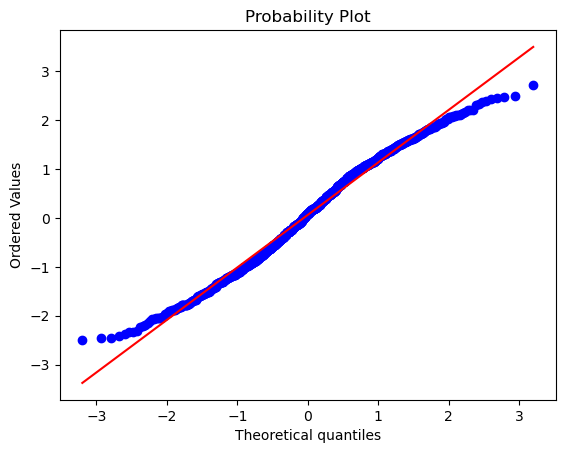

In [4]:
noised = diffusion.forward(1, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(199, s=5)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

100%|█████████████████████████| 10000/10000 [02:57<00:00, 56.37it/s, loss=0.700]


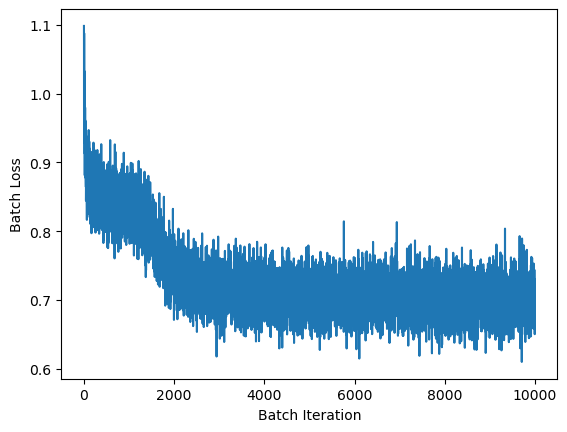

In [5]:
diffusion.train(1000, 10000)

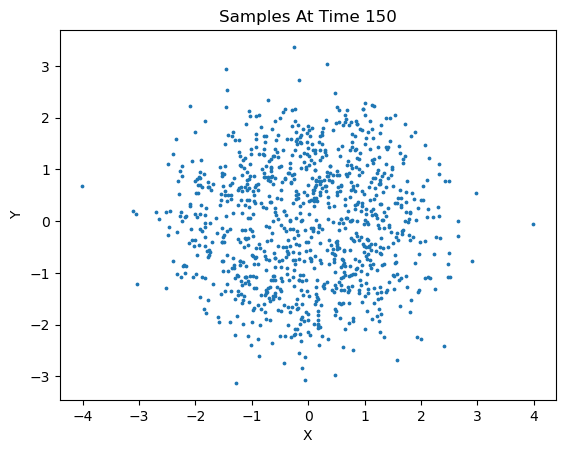

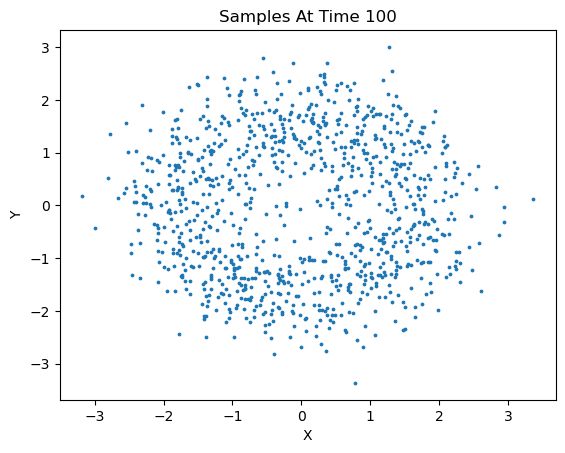

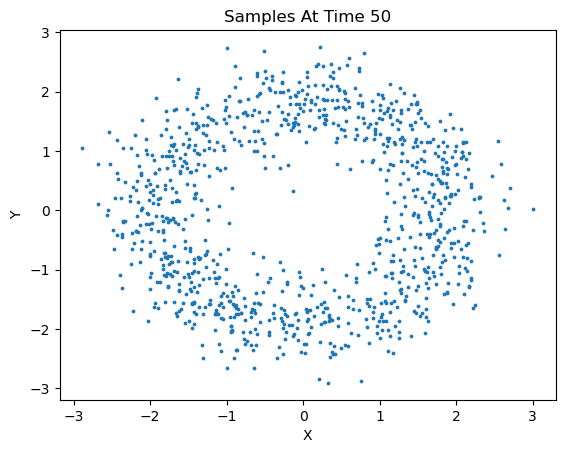

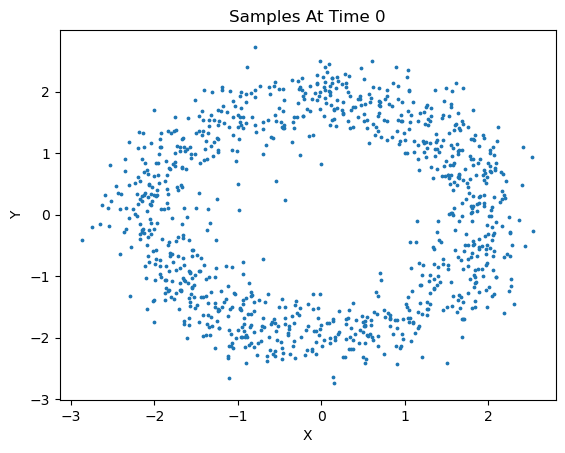

In [6]:
new_x = diffusion.sample(1000, 50, s=3)

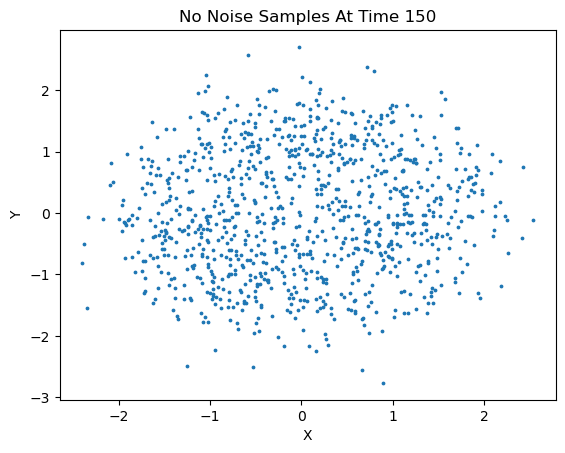

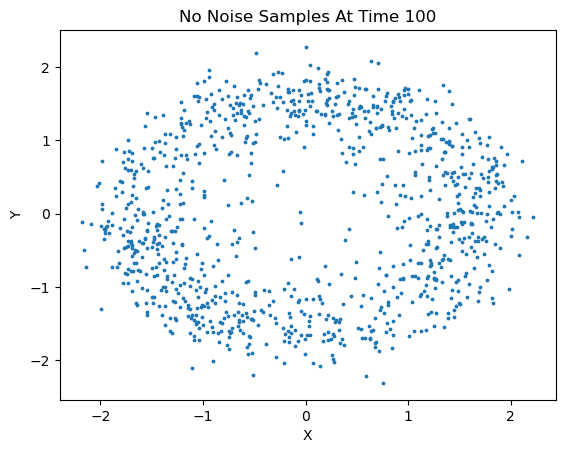

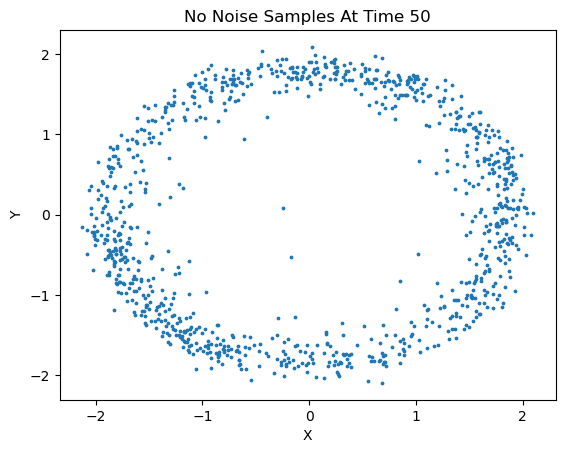

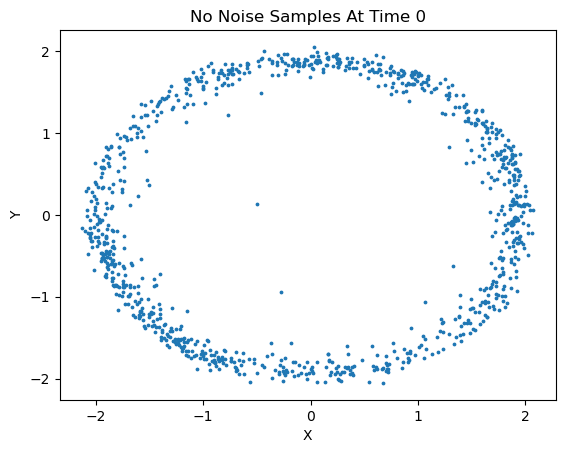

In [7]:
new_x = diffusion.sample(1000, 50, no_noise=True, s=3)

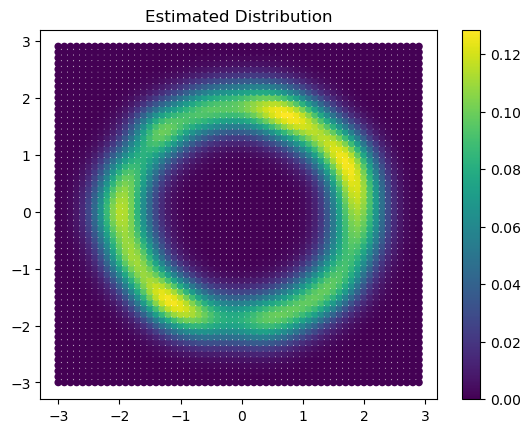

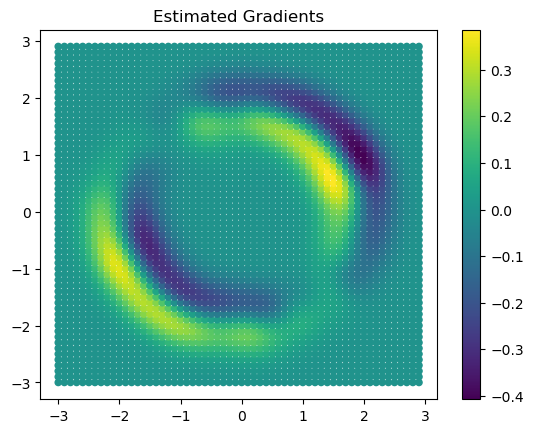

In [83]:
x_grid = torch.arange(-3,3,0.1)
y_grid = torch.arange(-3,3,0.1)
grid = torch.cartesian_prod(x_grid, y_grid)

probabilities = estimate_distribution(diffusion, 1000, grid, torch.full((len(grid),2), 0.3))
gradients = estimate_gradient(diffusion, 1000, grid, torch.full((len(grid),2), 0.3))
# Estimated Density Plot
plt.scatter(grid[:,0], grid[:,1], c=probabilities, s=20)
plt.colorbar()
plt.title('Estimated Distribution')
plt.show()
# Gradient Plot
plt.scatter(grid[:,0], grid[:,1], c=torch.sum(gradients, dim=1), s=20)
plt.colorbar()
plt.title('Estimated Gradients')
plt.show()

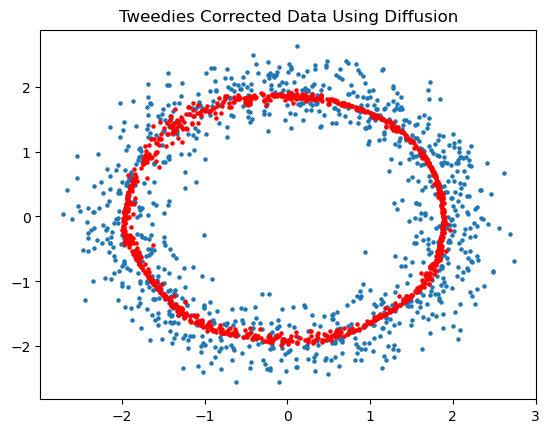

In [180]:
data_probabilities = estimate_distribution(diffusion, 5000, data, torch.full((len(data),2), 0.3))
data_gradients = estimate_gradient(diffusion, 5000, data, torch.full((len(data),2), 0.3))
theta_hat = tweedies(data, data_probabilities, data_gradients, torch.full((len(data),2), 0.09), clearance=0.0001)
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.scatter(theta_hat[:, 0], theta_hat[:, 1], color='red', s=5)
plt.title('Tweedies Corrected Data Using Diffusion')
plt.show()